In [1]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,1999)]

0.25.3


## Procesar datos

In [4]:
#crear directorio con data de delays agrupada por retraso 
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
    
for year in years:
    if not os.path.exists(tmp_dir+year+".csv"):
        print("Leyendo csv: {}".format(year))
        t = time.time()
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "DepDelay"], encoding="ISO 8859-1")    

        #formato mas feliz para fechas
        dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
        df["date"] = dates
        df = df[["date", "Year", "DepDelay"]]

        #sacamos outliers
        low = 0.25
        high = 0.75
        qiles = df.groupby("date")["DepDelay"].quantile([low, high]).unstack(level=1)
        mask =  (qiles.loc[df.date, low] < df.DepDelay.values) & \
                (df.DepDelay.values < qiles.loc[df.date, high])
        df = df.loc[mask.values]
        
        #agrupamos
        df = df.groupby(by=df['date'].dt.date).mean()
        df.to_csv(tmp_dir+year+".csv")
        del df 
    

Leyendo csv: 1994
Leyendo csv: 1995
Leyendo csv: 1996
Leyendo csv: 1997
Leyendo csv: 1998


1998.csv


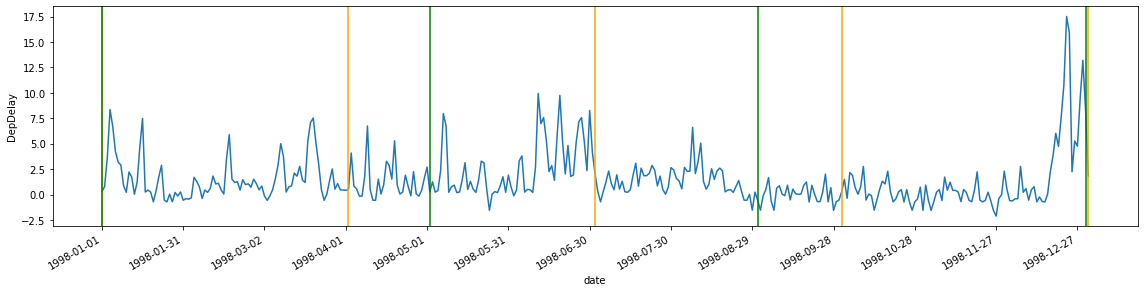

1996.csv


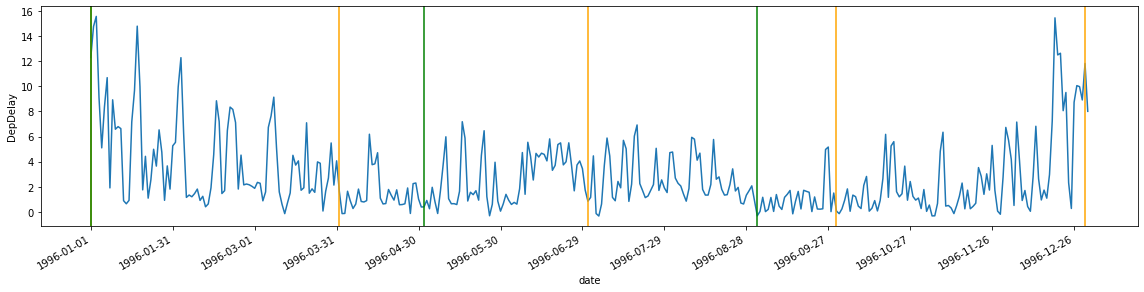

1994.csv


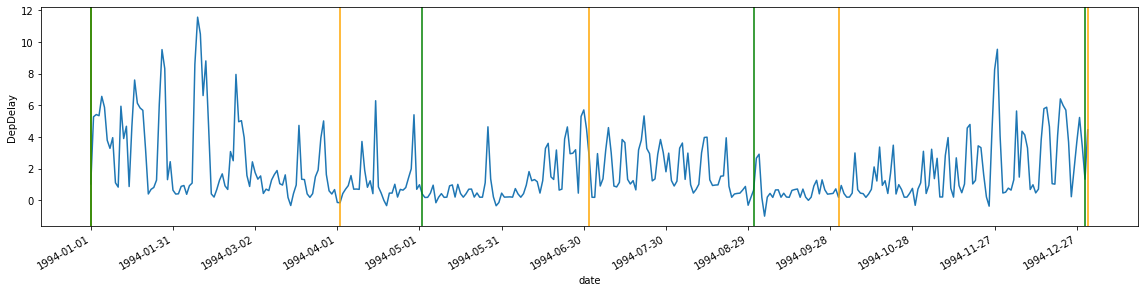

1997.csv


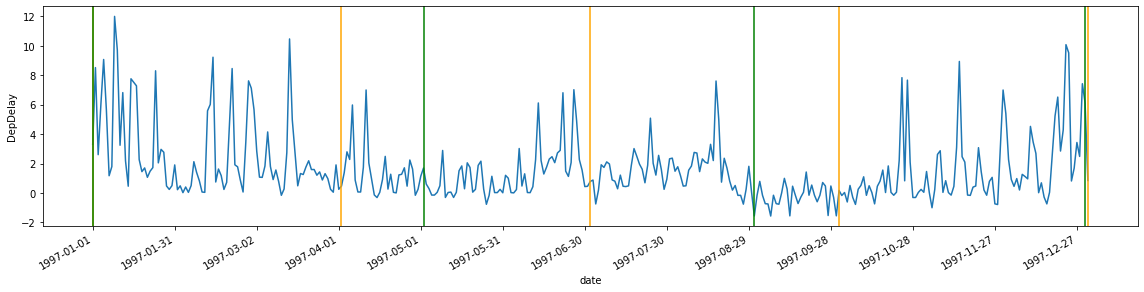

1995.csv


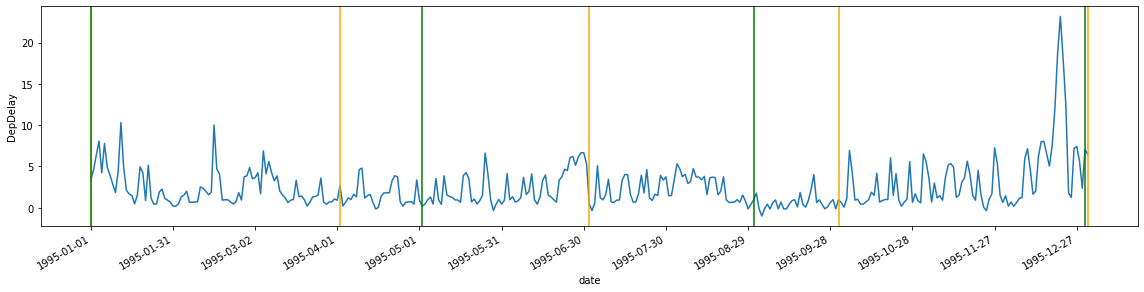

In [5]:
for filename in os.listdir(tmp_dir):
    if filename.endswith(".csv") and filename != "merged.csv": 
        print(filename)
        df = pd.read_csv(tmp_dir+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.DepDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            if i%30 != 0:
                xticks[i].set_visible(False)
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

In [14]:
#merge
if os.path.exists(tmp_dir+"merged.csv"):
    os.remove(tmp_dir+"merged.csv")
df = pd.DataFrame(columns=["date", "DepDelay"])
for filename in sorted(os.listdir(tmp_dir)):
    if filename.endswith(".csv") and filename != "merged.csv":
        print(filename)
        df_input = pd.read_csv(tmp_dir+filename)
        df = pd.concat([df, df_input], sort=True)
        
df.set_index('date')
df.to_csv(tmp_dir+"merged.csv")

1994.csv
1995.csv
1996.csv
1997.csv
1998.csv


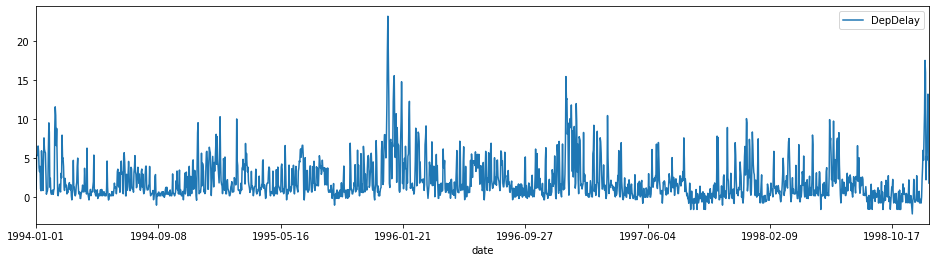

In [15]:
df = pd.read_csv(tmp_dir+"merged.csv")
df.plot(x="date", y="DepDelay", linestyle='-', figsize=(16,4))

## CML acá 

In [16]:
#delays = df["DepDelay"]
train_delays = df.loc[df["Year"]<1998]["DepDelay"]
print(train_delays)
print(df["DepDelay"])

0       1.035767
1       5.280788
2       5.422914
3       5.349147
4       6.570860
          ...   
1456    3.432095
1457    2.483896
1458    7.421718
1459    6.098639
1460    0.855528
Name: DepDelay, Length: 1461, dtype: float64
0        1.035767
1        5.280788
2        5.422914
3        5.349147
4        6.570860
          ...    
1821     4.753680
1822     9.449135
1823    13.206668
1824     8.342410
1825     1.822077
Name: DepDelay, Length: 1826, dtype: float64


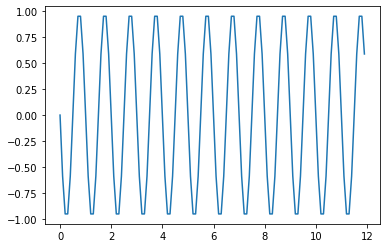

In [141]:
#para jugar con fases
time        = np.arange(0, 12,0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

In [26]:
import numpy as np
import math

max_grade = 1
phases = [i*math.pi/2 for i in range(4)]

# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]]

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals

    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 
    
lpr = lsqPredictor(phases, freqs, max_grade)
lpr.fit(train_delays)
#coefs = np.linalg.lstsq(A, old_delays, rcond=None)[0]


In [27]:
if "dl_pred" in df:
    del df["dl_pred"]

In [28]:
train_test_delays = df["DepDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 
df

,Unnamed: 0,DepDelay,Year,date,dl_pred
0,0,1.035767,1994.0,1994-01-01,4.020557
1,1,5.280788,1994.0,1994-01-02,3.446243
2,2,5.422914,1994.0,1994-01-03,3.093322
3,3,5.349147,1994.0,1994-01-04,3.298914
4,4,6.570860,1994.0,1994-01-05,3.979475
...,...,...,...,...,...
1821,360,4.753680,1998.0,1998-12-27,3.133104
1822,361,9.449135,1998.0,1998-12-28,2.622398
1823,362,13.206668,1998.0,1998-12-29,2.670925
1824,363,8.342410,1998.0,1998-12-30,3.196013


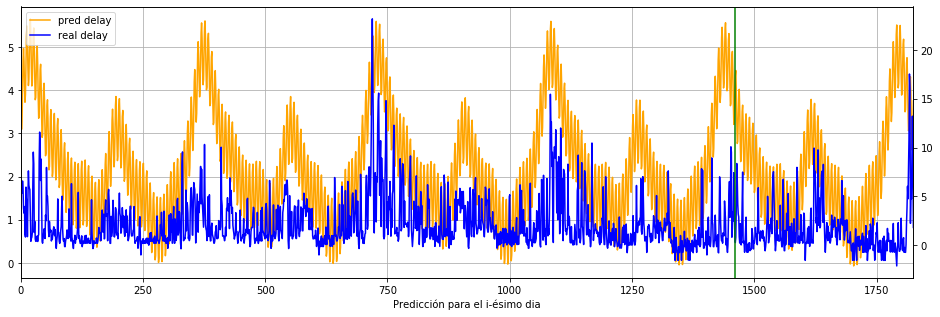

In [29]:
plt.figure(figsize=(16,5))
plt.xlabel('Predicción para el i-ésimo dia')


ax1 = df.dl_pred.plot(color='orange', grid=True, label='pred delay')
ax2 = df.DepDelay.plot(color='blue', grid=True, secondary_y=True, label='real delay')

xticks = ax1.xaxis.get_major_ticks()
plt.axvline(x=len(train_delays), color="green")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

## BORRAR ARCHIVOS

In [3]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [4]:
#borrar merged
os.remove(tmp_dir+"merged.csv")

In [5]:
#borrar tmp
shutil.rmtree(tmp_dir)